# Timeseries with recurrent neural networks

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)
%matplotlib inline
plt.style.use('dark_background')

# 1.0 Sunspots
## 1.1 Loading data

In [2]:
from mads_datasets import DatasetFactoryProvider, DatasetType
sunspotfactory = DatasetFactoryProvider.create_factory(DatasetType.SUNSPOTS)
sunspotfactory.download_data()

2025-02-15 14:44:20.002 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/sunspots
2025-02-15 14:44:20.002 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/sunspots/sunspots.txt


First let's look at the raw data.

In [3]:
import numpy as np
f = sunspotfactory.filepath
f.exists(), f

(True, PosixPath('/home/sarmad/.cache/mads_datasets/sunspots/sunspots.txt'))

In [4]:
spots = np.genfromtxt(f, usecols=(2,3))
spots

array([[1749.042,   96.7  ],
       [1749.123,  104.3  ],
       [1749.204,  116.7  ],
       ...,
       [2024.873,  152.5  ],
       [2024.958,  154.5  ],
       [2025.042,  137.   ]], shape=(3313, 2))

This is data on sunspots, since 1749, in a pandas dataframe. Let us cast this to a `float32` Torch Tensor.

We first need to get the numpy data out of the pandas, and the cast that to a float32 Tensor.

In [5]:
import torch
tensordata = torch.from_numpy(spots[:, 1]).type(torch.float32)
tensordata

tensor([ 96.7000, 104.3000, 116.7000,  ..., 152.5000, 154.5000, 137.0000])

<font color='green'>

**Code modified** to work by clearing the plot and then plotting it again.
</font>

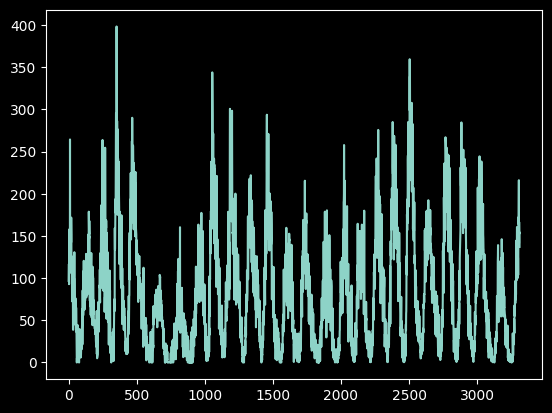

In [6]:
plt.clf()
plt.plot(tensordata)
plt.show()

## 1.2 Train-test split
There seems to be some pattern. But also a lot of noise. We need to take this into account for our final model: it might be hard to get very high accuracy, because we dont have any additional features (could you think of possible relevant features?).

So let's make a train-test split, and normalize on the trainset. Note that we split on past-future! (Why is this important?)

In [7]:
# Train test split
split = 2500
train = tensordata[:split]

norm = max(train)
test = tensordata[split:]

train = train / norm
test = test/ norm

What would go wrong if you normalize on the max of the testset?

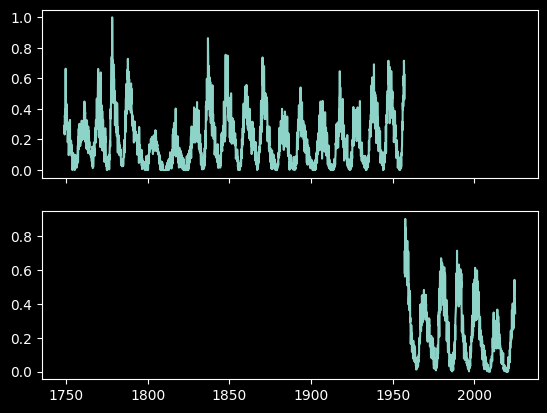

In [8]:
# reduce steps back to months, starting in 1749
idx0 = torch.arange(0, len(train)) / 12 + 1749
idx1 = torch.arange(0, len(test)) / 12 + idx0.max()
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(idx0, train)
axs[1].plot(idx1,test)

## 1.3 Windowing

Now, let's use our windowed datagenerator.

Regarding the windowsize, we will have to ask ourselves: what is a reasonable time, we will need to look into the past to be able to predict the future? If we make it too long, we will get irrelevant data (eg, does the amount of sunspots a hundred years still impact significantly the sunspots in 2020? If you think so, you should increase your window by a lot!)

In [9]:
from mads_datasets import datatools

window_size = sunspotfactory.settings.window_size
print(f"windowsize: {window_size}")

idx = datatools.window(train, window_size)
trainset = train[idx]
idx = datatools.window(test, window_size)
testset = test[idx]
trainset.shape, testset.shape

windowsize: 26


(torch.Size([2475, 26]), torch.Size([788, 26]))

Ok, that is looking good. We squeezed out 2475 training examples out of this long, single timeseries.

## 1.4 A custom dataset

Let's make the data 3D, just as our timeseries model will need to have it. We just have one feature, so that is just a dimension of 1.

In [10]:
trainset = trainset[...,None]
testset = testset[..., None]
trainset.shape, testset.shape

(torch.Size([2475, 26, 1]), torch.Size([788, 26, 1]))

We can implement a Dataset in PyTorch. 
According to the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)
> A custom Dataset class must implement three functions: `__init__`, ` __len__`, and `__getitem__`


The functions with the double underscores are called "dunder" function. 
The `__len__` function is the function that is called when you do `len(object)`, the `__getitem__` function is called when you do `object[idx]` and `idx` is passed as an argument.

We can inherit the `Dataset` class, and if we implement a `__len__` and `__getitem__` function, we are good.

In [11]:
from mads_datasets.base import DatasetProtocol
from typing import Tuple
Tensor = torch.Tensor

class SunspotDataset(DatasetProtocol):
    def __init__(self, data: Tensor, horizon: int) -> None:
        self.data = data
        self.size = len(data)
        self.horizon = horizon

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        # get a single item
        item = self.data[idx]
        # slice off the horizon
        x = item[:-self.horizon,:]
        y = item[-self.horizon:,:].squeeze(-1) # squeeze will remove the last dimension if possible.
        return x, y

Let us test if this works as expected

In [12]:
datashape = (100, 10, 2)
dummydata = torch.randint(0, 10, datashape)
dummydataset = SunspotDataset(dummydata, horizon=2)
len(dummydataset) # uses the __len__ method

100

In [13]:
x, y = dummydataset[0] # uses the __getitem__ method
x.shape, y.shape # no squeeze because we have dimension 2 as the last dimension

(torch.Size([8, 2]), torch.Size([2, 2]))

Ok, now we apply this on the trainset.

In [14]:
trainset.shape

torch.Size([2475, 26, 1])

In [15]:
horizon = 3
traindataset = SunspotDataset(trainset, horizon=horizon)
testdataset = SunspotDataset(testset, horizon=horizon)

In [16]:
traindataset.data.shape

torch.Size([2475, 26, 1])

In [17]:
x, y = traindataset[1]
x.shape, y.shape # here we see the squeeze happening

(torch.Size([23, 1]), torch.Size([3]))

## 1.5 A Dataloader
This seems to work as well. 
Again, everything is wrapped into the dataset factory, which will give you windowed and batched streamers.

In [18]:
sunspotfactory.settings

dataset_url: https://www.sidc.be/SILSO/DATA/SN_m_tot_V2.0.txt
filename: sunspots.txt
name: sunspots
unzip: False
formats: []
digest: b0c58f706c1e14a1faaa35635b51679e
horizon: 3
window_size: 26

In [19]:
from mltrainer.preprocessors import BasePreprocessor
preprocessor = BasePreprocessor()

streamers = sunspotfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-02-15 14:44:22.261 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/sarmad/.cache/mads_datasets/sunspots
2025-02-15 14:44:22.262 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/sarmad/.cache/mads_datasets/sunspots/sunspots.txt


Can you make sense of all the output?
What is going on? Is that what you expected?

In [20]:
x, y = next(iter(trainstreamer))
type(x), len(x), x[0].shape, y[0].shape

(torch.Tensor, 32, torch.Size([23, 1]), torch.Size([3]))

<font color='green'>

**Here, 32 is the batch size, and train set is divided with the as x=[23, 1] and y=[3] by using the `SunspotDataset` function.**

</font>


In [21]:
x.shape, y.shape

(torch.Size([32, 23, 1]), torch.Size([32, 3]))

What do you think these numbers are?

<font color='green'>

**The `len(train)` gives the approx numbers of mini-batches to be iterated with the batch size of 32.**

</font>

In [22]:
len(train), len(valid)

(82, 19)

# 2 Exploring baseline models
## 2.1 Naive models

The most basic prediction is a Naive model. 

- What is a naive prediction of the temperature for tomorrow? Well, the temperature of today.
- The stock market for tomorrow? Same as today.
- Bitcoin for march 16th of 2028? Same as march 15th 2028.

In general, this is a super simple model without any parameters but often much better than you would expect, because the temparature of today will be close to the temperature of tomorrow.

In general, you can say that f is a function that you feed the current moment, which is a real number, and it will map it to one step into the future, which is also a real number.

$$ f: x_t \in \mathcal{R} \to x_{t+1} \in \mathcal{R}$$

but $f$ is just the Identity function $f(x) = x$, so one step into the future is the same as the current timestep.

This gives rise to the MASE, the Mean Absolute Scaled Error: It is the mean absolute error of the forecast values (the actual model) 
$\frac{1}{J}\sum_j|e_j|$, but scaled by the mean absolute error of the in-sample one-step naive forecast $|Y_t-Y_{t-1}|$ (the naive model):

$$ MASE = \frac{\frac{1}{J}\sum_j|e_j|}{
\frac{1}{T-1} \sum_{t=2}^{T}|Y_t-Y_{t-1}|} $$

This takes a moment in time $t$, and calculates the difference with one step back $t-1$.

In other words, the MASE compares the MAE of your actual model to the MAE of the naive model. 

E.g. if the error of your model is 1, and the error of the naive model is 10, your MASE is 0.1, meaning you are much better than the naive prediction.

MASE values above 1 are really bad, because it means the naive function outperformed your actual model, everything below (ideally close to 0) is an improvement.

We will implement this ourselves. First the naive prediction:

In [23]:
Tensor = torch.Tensor

def naivepredict(x: Tensor, horizon: int) -> tuple[Tensor, Tensor]:
    assert horizon > 0
    yhat = x[...,-horizon:, :].squeeze(-1)
    return yhat

In [24]:
yhat = naivepredict(x, horizon) #this should be the same horizon you used to create the dataset
yhat.shape

torch.Size([32, 3])

With the naive prediction, we can calculate the MAE

In [25]:
def mae(y: np.ndarray, yhat: np.ndarray) -> float:
    return np.mean(np.abs(y-yhat))

In [26]:
mae(y.detach().numpy(), yhat.detach().numpy())

np.float32(0.069811545)

This error is not deterministic, because of the shuffling in the dataset.

Now, we want to calculate the naive MAE for every batch, to get the average, expected MAE for the naive prediction

In [27]:
def naivenorm(train , horizon: int):
    elist = []
    streamer = train.stream()

    for _ in range(len(train)):
        x, y = next(iter(streamer))
        yhat = naivepredict(x, horizon)
        e = mae(y.numpy(), yhat.numpy())
        elist.append(e)
    return torch.mean(torch.tensor(elist))
naivenorm(train, 1)

tensor(0.0563)

This means, a MAE close to this number is not impressive at all. We need to get below this if we want to go beyond the naive prediction.
We can wrap everything in a class, so it is neatly organized.

This example also illustrates two other dunder methods, `__repr__` and `__call__`

In [28]:
from mads_datasets.base import BaseDatastreamer
Tensor = torch.Tensor
class MASE:
    def __init__(self, train: BaseDatastreamer, horizon: int):
        self.scale = self.naivenorm(train, horizon)

    def __repr__(self) -> str:
        # __repr__ is what is returned if you print the class to the screen
        return f"MASE(scale={self.scale:.3f})"

    def naivenorm(self, train: BaseDatastreamer, horizon: int) -> Tensor:
        elist = []
        streamer = train.stream()
        for _ in range(len(train)):
            x, y = next(iter(streamer))
            yhat = self.naivepredict(x, horizon)
            e = self.mae(y.numpy(), yhat.numpy())
            elist.append(e)
        return torch.mean(torch.tensor(elist))

    def naivepredict(self, x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
        assert horizon > 0
        yhat = x[...,-horizon:, :].squeeze(-1)
        return yhat

    def mae(self, y: np.ndarray, yhat: np.ndarray) -> float:
        return np.mean(np.abs(y-yhat))

    def __call__(self, y: np.ndarray, yhat: np.ndarray) -> float:
        # __call__ lets us call the class as a function
        return self.mae(y, yhat) / self.scale

In [29]:
mase = MASE(train, horizon)
mase # __repr__ in action

MASE(scale=0.062)

In [30]:
mase(y.numpy(), yhat.numpy()) # __call__ in action

tensor(1.1251)

## 2.2 Linear model
Ok, we have everything in place. Let's start with a slightly more advanced model than a naive one.

We start with a linear baselinemodel, of just a single `Linear` layer with one unit. This is equal to a linear model.

**NOTE** A Neural Network (consisting of Linear layers AND activation layers) is NOT a simple model; if your model is deep & wide enough, this is a universal function approximator! That means a neural network is capable, in theory, of approximating EVERY function. In this case we use a single layer, with a minimum amount of units; that's why this is a simple model!

Check out the sourcecode (tip: VS code let's you do so easily by pressing F12, or by right-clicking the mouse on a function and selecting `Go to Definition`)

In [31]:
from mltrainer import rnn_models, metrics
observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)
x, y = next(iter(trainstreamer))
x.shape, y.shape

(torch.Size([32, 23, 1]), torch.Size([32, 3]))

Let's have a look at our random model

In [32]:
yhat = model(x)
yhat.shape

torch.Size([32, 3])

In [33]:
mase = MASE(train, horizon)
mase(y.detach().numpy(), yhat.detach().numpy())

tensor(5.4312)

Oh boy! Untrained, this is actually much much worse than a naive model... Let's start training...

First, we add a regular MAE too.

In [34]:
# mae = metrics.MAE()
mae(yhat.detach().numpy(), y.detach().numpy())

np.float32(0.33678243)

In [35]:
from loguru import logger
import sys
logger.remove()
logger.add(sys.stderr, level="SUCCESS")

1

In [36]:
from mltrainer import TrainerSettings, ReportTypes
from pathlib import Path

log_dir = Path("../../models/rnn/").resolve()
settings = TrainerSettings(
    epochs=100,
    metrics=[mase, mae],
    logdir=log_dir,
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.GIN],
    scheduler_kwargs = {"factor": 0.5, "patience": 5},
    earlystop_kwargs = {
        "save": False,
        "verbose": True,
        "patience": 10,
    }
)

In [37]:
device = "cpu" # faster than mps in this case

In [38]:
from mltrainer import Trainer
import gin

gin.parse_config_file("model.gin")

observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)

trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.MSELoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device=device,
    )
trainer.loop()

/home/sarmad/anaconda3/envs/conda_kernel/lib/python3.11/site-packages/gin/config.py:615: FutureWarning: `NLLLoss2d` has been deprecated. Please use `NLLLoss` instead as a drop-in replacement and see https://pytorch.org/docs/main/nn.html#torch.nn.NLLLoss for more details.
  decorated_class = decorating_meta(cls.__name__, (cls,), overrides)
 45%|████▌     | 45/100 [00:03<00:04, 13.40it/s]


If you have a look at Tensorboard, you can see the model is learning!

In [39]:
x, y = next(iter(validstreamer))
yhat = model(x)
mae(y.detach().numpy(), yhat.detach().numpy()), mase(y.detach().numpy(), yhat.detach().numpy())

(np.float32(0.047179576), tensor(0.7609))

And, yes, the MASE dropped below 1! This is a good start.

Let's visualize this.

<Figure size 640x480 with 0 Axes>

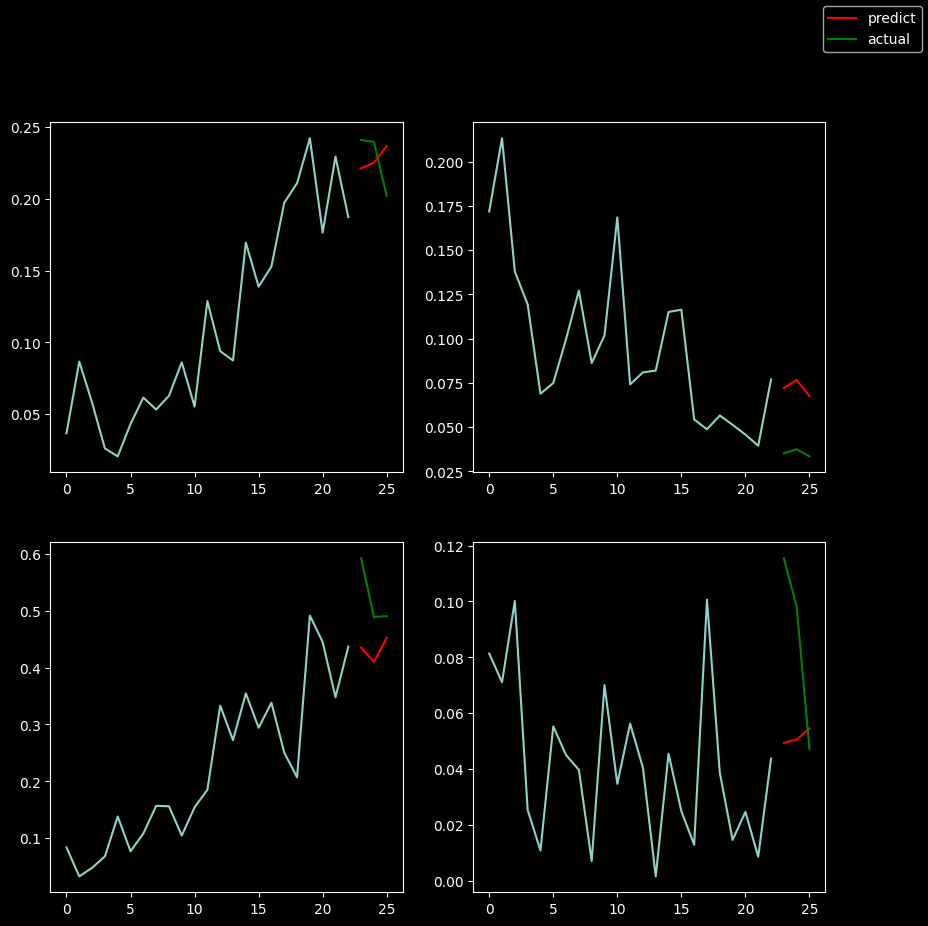

In [40]:
plt.clf()
k = 4
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.ravel()

timesteps = x.shape[1]
idx0 = [*range(timesteps)]
idx1 = [(i + timesteps) for i in range(horizon)]
for i in range(k):
    axs[i].plot(idx0, x[i])
    axs[i].plot(idx1, yhat[i].detach(), color="red", label="predict")
    axs[i].plot(idx1, y[i], color="green", label="actual")
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels)
plt.show()

Well, it is not perfect, obviously. But it does seem to capture the trend more often that random.

## 2.3 Simple RNN

Let's invoke the basic RNN without gates.

Input size is 1, because we have 1 feature. We follow [the batch_first convention](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). Hidden size is the inner dimension of the RNN, and thus the dimensionality of the output.

What would happen if we feed this data with dimensions `(batch, sequence_length)`?

In [41]:
x = torch.randn((32, 25))
rnn = torch.nn.RNN(input_size=1, hidden_size=1, batch_first=True)
try:
    yhat = rnn(x)
except RuntimeError as e:
    print(e)

input.size(-1) must be equal to input_size. Expected 1, got 25


Note how it expects 3 dimensions : `(batch, sequence_length, features)`, even though we have just one feature.

In [42]:
x, y = next(iter(trainstreamer))
x.shape, y.shape

(torch.Size([32, 23, 1]), torch.Size([32, 3]))

In [43]:
out, hidden = rnn(x)
out.shape, hidden.shape

(torch.Size([32, 23, 1]), torch.Size([1, 32, 1]))

This works as expected. Let's increase the hidden dimension (why would you do that?)

<font color='green'>

**Increasing the hidden dimension means to increase the model complexity which can lead to better generalization of the data with more hidden layers, but this also increase the training time as it requires more iterations and calculations for learning better weights parameters.**

</font>


In [44]:
rnn = torch.nn.RNN(input_size=1, hidden_size=10, batch_first=True)
out, hidden = rnn(x)
out.shape, hidden.shape

(torch.Size([32, 23, 10]), torch.Size([1, 32, 10]))

And let's add multiple stacked layers of RNN (can you visualize how this would work?)

<font color='green'>

**Stacked RNN layers, works almost similar to the CNN `ModuleList`. The output from the one RNN-block is provided to the next RNN-block as the input to extract more features from the provided data.**

</font>


In [45]:
rnn = torch.nn.RNN(
    input_size=1,
    hidden_size=10,
    num_layers=3,
    batch_first=True)
out, hidden = rnn(x)
out.shape, hidden.shape

(torch.Size([32, 23, 10]), torch.Size([3, 32, 10]))

To get the output of the last timestep, we need to throw away the rest.

In [46]:
out = out[:,-1,:]
out.shape

torch.Size([32, 10])

So, let's wrap this up in a model. Study the implementation in `rnn_models.BaseRNN`.

Do you understand what the linear layer does? What would happen if you remove it?

<font color='green'>

**Answer**
- The RNN outputs a hidden state, not a prediction.
- The linear layer converts the hidden state into the actual prediction (yhat).
- Without the linear layer, we would have hidden states but no meaningful output.

</font>

In [47]:
from mltrainer import metrics, rnn_models

mase = metrics.MASE(train, horizon)
mae = metrics.MAE()

In [48]:
settings.epochs = 10
# settings.metrics = [mase, mae]
device = "cpu" # still faster than mps

In [49]:
gin.parse_config_file("model.gin")

observations = window_size - horizon
model = rnn_models.BaseRNN(horizon=horizon)
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.MSELoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device=device,
    )
trainer.loop()

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Does this improve over the linear model?
By how much? Is there a difference between loss and MASE? 

Use the tensorboard to find this out!

What does it mean?

Can you improve the model by tweaking it?

<font color='green'>

The MAE and MASE are not that different from the linear model. We can increase the `num_layers` to make a stacked RNN to learn better generalization. The changes are made in the `model.gin` file.
</font>


In [50]:
x, y = next(iter(validstreamer))
yhat = model(x)
mae(y, yhat), mase(y, yhat)

(tensor(0.0526, grad_fn=<MeanBackward0>),
 tensor(0.8480, grad_fn=<DivBackward0>))

<Figure size 640x480 with 0 Axes>

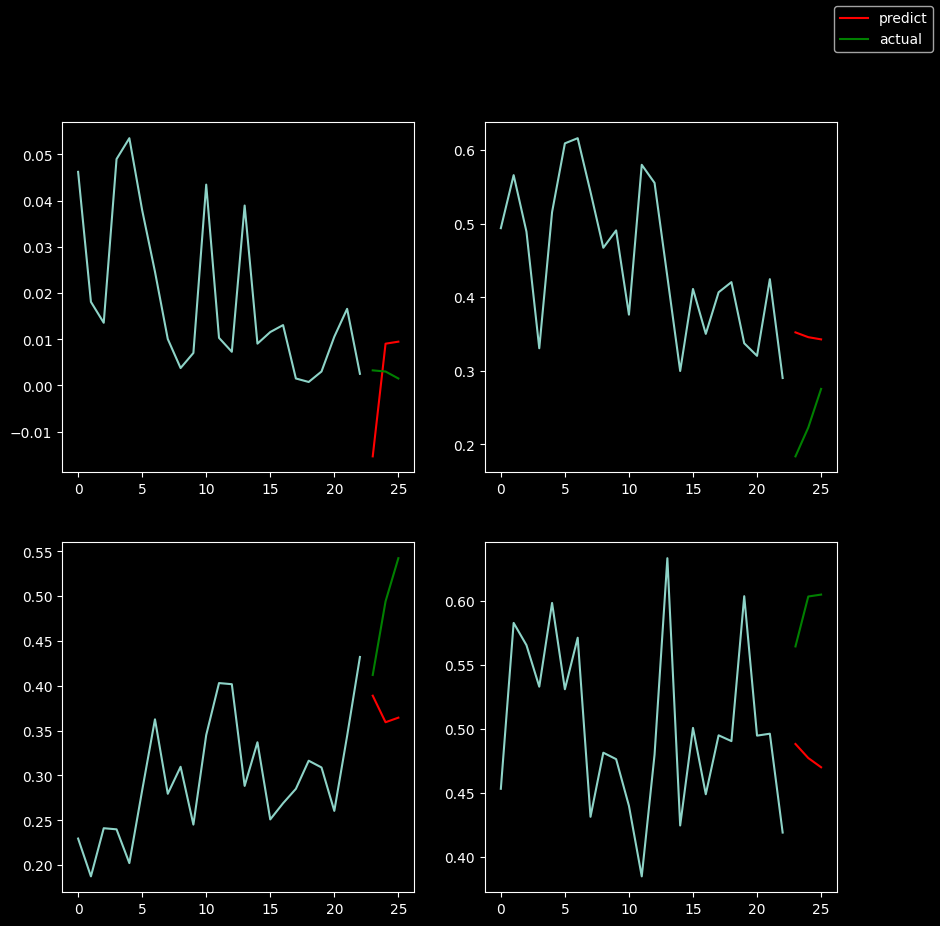

In [51]:
plt.clf()
k = 4
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.ravel()

timesteps = x.shape[1]
idx0 = [*range(timesteps)]
idx1 = [(i + timesteps) for i in range(horizon)]
for i in range(k):
    axs[i].plot(idx0, x[i])
    axs[i].plot(idx1, yhat[i].detach(), color="red", label="predict")
    axs[i].plot(idx1, y[i], color="green", label="actual")
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels)
plt.show()

<font color='green'>

**By increasing the `hidden_size` and `num_layers`, we are able to increase the performance of the model, as we can validate by the reduced MAE and MASE.**
</font>


In [52]:


gin.parse_config_file("model.gin")

observations = window_size - horizon
model = rnn_models.BaseRNN(hidden_size=128, num_layers=5, horizon=horizon)
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=torch.nn.MSELoss(),
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device=device,
    )
trainer.loop()

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [53]:
x, y = next(iter(validstreamer))
yhat = model(x)
mae(y, yhat), mase(y, yhat)

(tensor(0.0475, grad_fn=<MeanBackward0>),
 tensor(0.7659, grad_fn=<DivBackward0>))